In [1]:
import os
import sys
sys.path.extend([os.path.join(os.path.dirname(os.getcwd()), "tests")])

import matplotlib.pyplot as plt
import numpy as np

from jaxparrow import cyclogeostrophy, geostrophy
from tests import gaussian_eddy as ge

%reload_ext autoreload
%autoreload 2

# Gaussian eddy

We want to use a gaussian eddy for our functional tests, as analytical solutions can be derived in that setting.

The gaussian eddy we consider is of the form $\eta = \eta_0 \exp^{-(r/R_0)^2}$, with $R_0$ its radius, $\eta_0$ the SSH anomaly at its center, and $r$ the radial distance. 
We choose to use a constant spatial step in meters.

In [2]:
# Alboran sea settings
R0 = 50e3
ETA0 = .1
LAT = 36

dxy = 3e3

## Simulating the eddy

In [3]:
X, Y, R, dXY, coriolis_factor, ssh, u_geos, v_geos, u_cyclo, v_cyclo = ge.simulate_gaussian_eddy(R0, dxy, ETA0, LAT)

We just make sure that the grids are correct.

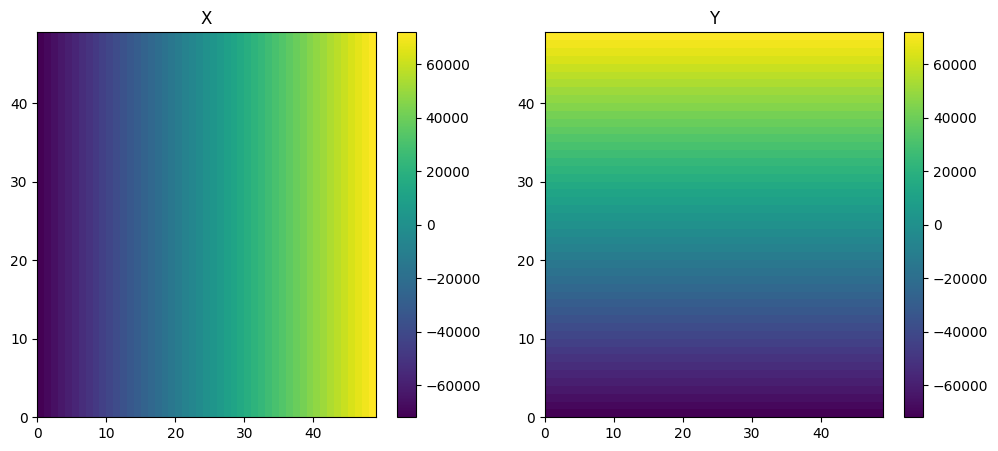

In [4]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_title("X")
im = ax1.pcolormesh(X, shading="auto")
plt.colorbar(im, ax=ax1)
ax2.set_title("Y")
im = ax2.pcolormesh(Y, shading="auto")
plt.colorbar(im, ax=ax2)
plt.show()

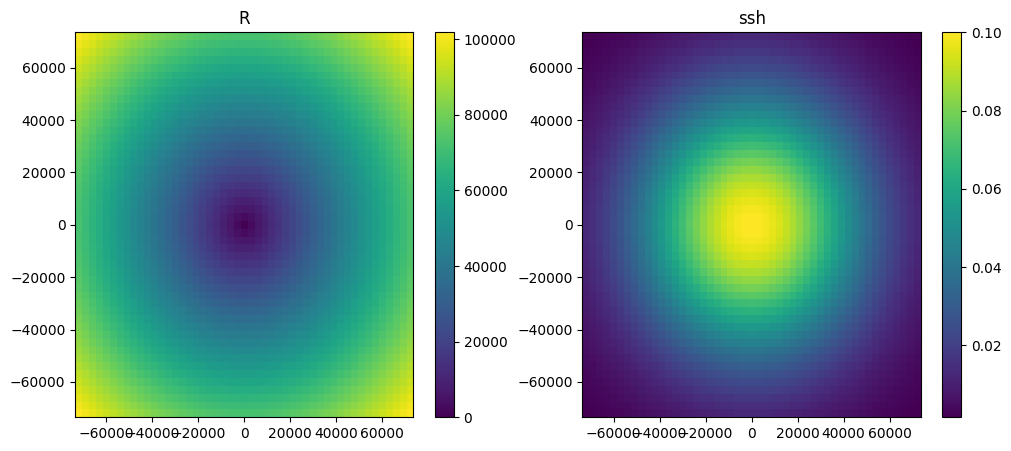

In [5]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_title("R")
im = ax1.pcolormesh(X, Y, R, shading="auto")
plt.colorbar(im, ax=ax1)
ax2.set_title("ssh")
im = ax2.pcolormesh(X, Y, ssh, shading="auto")
plt.colorbar(im, ax=ax2)
plt.show()

## Geostrophic azimuthal velocity

### Simulated

$$u_g = 2y \frac{g \eta_0}{f R_0^2} \exp^{-(r/R_0)^2} = 2y \frac{g \eta}{f R_0^2}$$

$$v_g = -2x \frac{g \eta_0}{f R_0^2} \exp^{-(r/R_0)^2} = -2x \frac{g \eta}{f R_0^2}$$

In [6]:
azim_geos = ge.compute_azimuthal_magnitude(u_geos, v_geos)

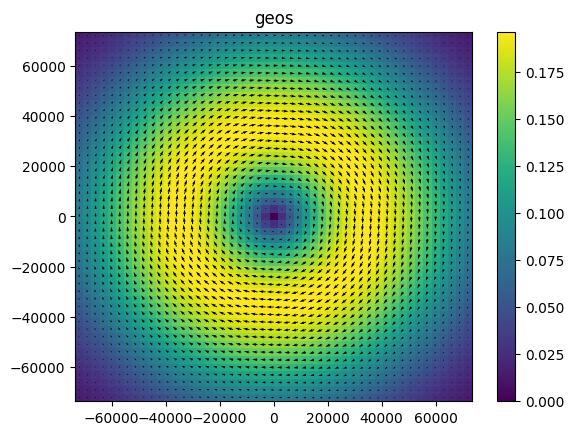

In [7]:
ax = plt.subplot()
ax.set_title("geos")
im = ax.pcolormesh(X, Y, azim_geos, shading="auto")
plt.colorbar(im, ax=ax)
ax.quiver(X, Y, u_geos, v_geos, color='k')
plt.show()

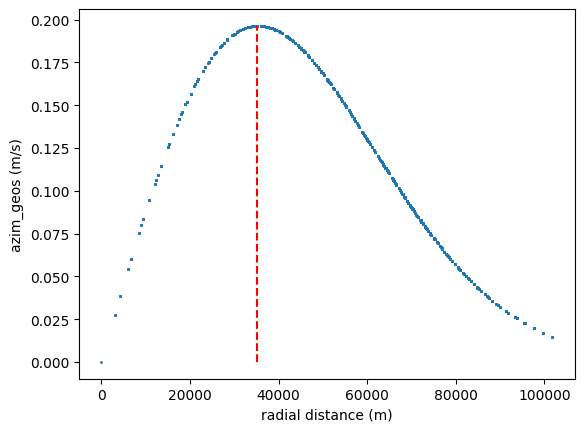

In [8]:
ax = plt.subplot()
ax.set_xlabel("radial distance (m)")
ax.set_ylabel("azim_geos (m/s)")
ax.scatter(R.flatten(), azim_geos.flatten(), s=1)
ax.vlines(R.flatten()[np.abs(azim_geos).flatten().argmax()], 
          ymin=azim_geos.min(), ymax=azim_geos.max(), colors="r", linestyles="dashed")
plt.show()

### Geostrophic balance

$f\mathbf{k} \times \mathbf{u_g} = -g \nabla \eta$

In [9]:
u_geos_est, v_geos_est = geostrophy(ssh, dXY, dXY, coriolis_factor, coriolis_factor)
u_geos_est, v_geos_est = ge.reinterpolate(u_geos_est, axis=0), ge.reinterpolate(v_geos_est, axis=1)
azim_geos_est = ge.compute_azimuthal_magnitude(u_geos_est, v_geos_est)


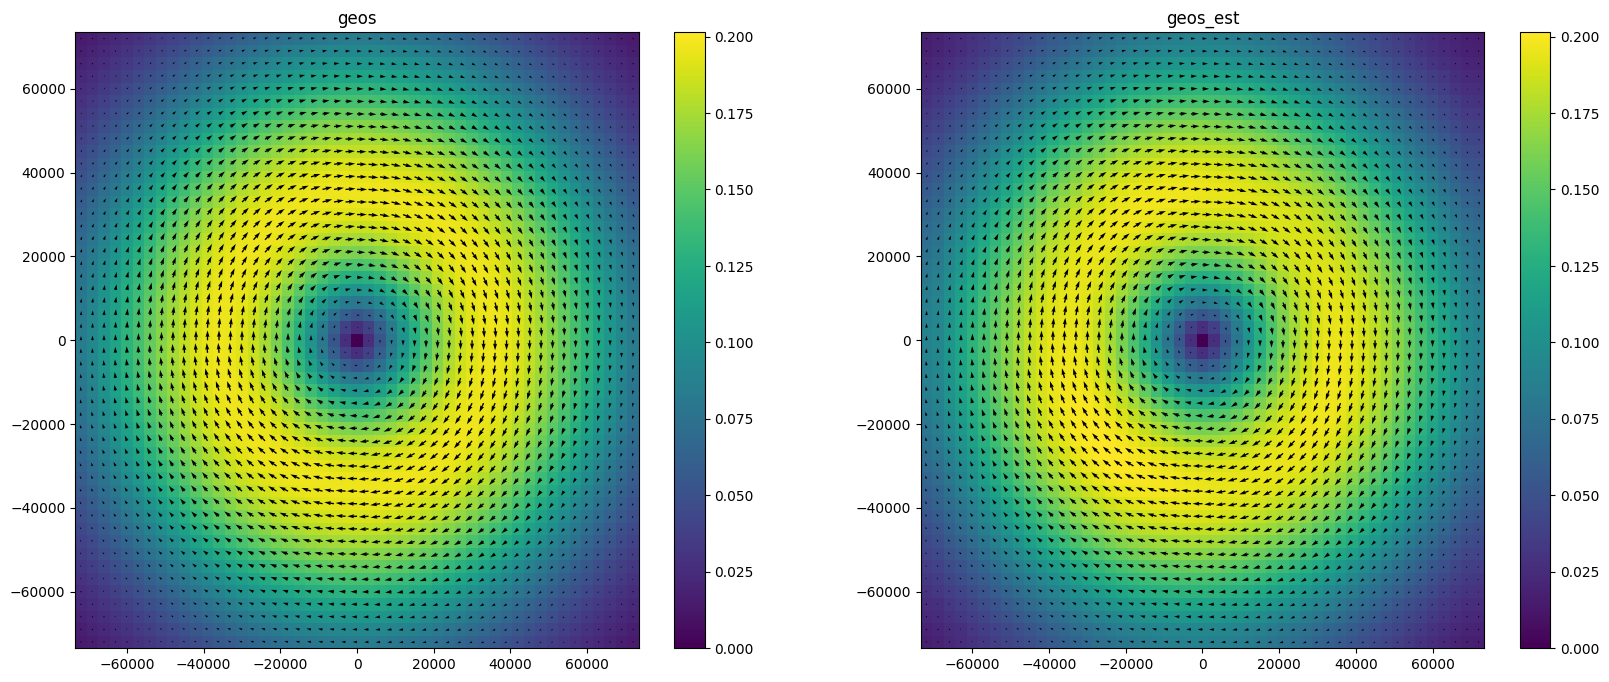

In [10]:
vmax = np.max([azim_geos, azim_geos_est])
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.set_title("geos")
im = ax1.pcolormesh(X, Y, azim_geos, shading="auto", vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax1)
ax1.quiver(X, Y, u_geos, v_geos, color='k')
ax2.set_title("geos_est")
im = ax2.pcolormesh(X, Y, azim_geos_est, shading="auto", vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax2)
ax2.quiver(X, Y, u_geos_est, v_geos_est, color='k')
plt.show()

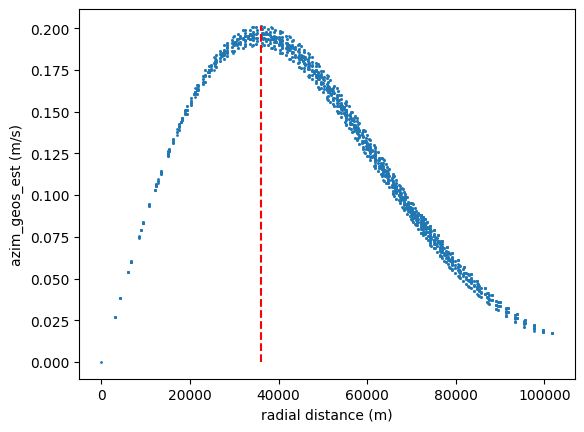

In [11]:
ax = plt.subplot()
ax.set_xlabel("radial distance (m)")
ax.set_ylabel("azim_geos_est (m/s)")
ax.scatter(R.flatten(), azim_geos_est.flatten(), s=1)
ax.vlines(R.flatten()[np.abs(azim_geos_est).flatten().argmax()], 
          ymin=azim_geos_est.min(), ymax=azim_geos_est.max(), colors="r", linestyles="dashed")
plt.show()

In [12]:
ge.compute_rmse(u_geos, u_geos_est), ge.compute_rmse(v_geos, v_geos_est)

(0.0029276521985262824, 0.0029276521985262824)

## Cyclogeostrophic azimuthal velocity

### Gradient wind analytical solution

$$V_{gr}=\frac{2V_g}{1+\sqrt{1+4V_g/(fR_0)}}$$

$$u_{gr} = u_g + sin(\theta) \frac{V_{gr}^2}{fR_0}$$
$$v_{gr} = v_g - cos(\theta) \frac{V_{gr}^2}{fR_0}$$

In [13]:
azim_cyclo = ge.compute_azimuthal_magnitude(u_cyclo, v_cyclo)

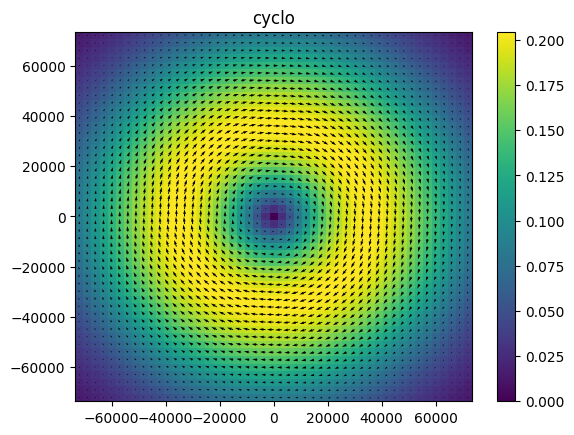

In [14]:
ax = plt.subplot()
ax.set_title("cyclo")
im = ax.pcolormesh(X, Y, azim_cyclo, shading="auto")
plt.colorbar(im, ax=ax)
ax.quiver(X, Y, u_cyclo, v_cyclo, color='k')
plt.show()

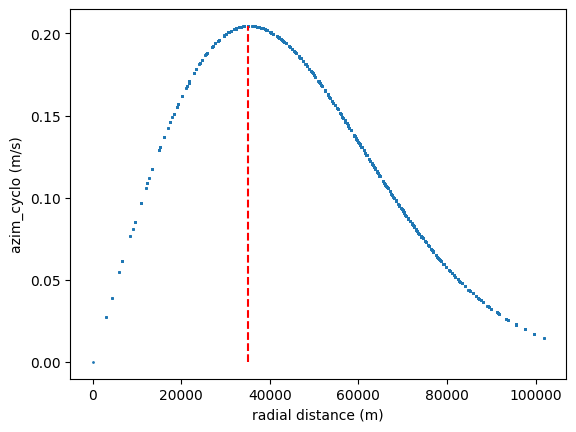

In [15]:
ax = plt.subplot()
ax.set_xlabel("radial distance (m)")
ax.set_ylabel("azim_cyclo (m/s)")
ax.scatter(R.flatten(), azim_cyclo.flatten(), s=1)
ax.vlines(R.flatten()[np.abs(azim_cyclo).flatten().argmax()], 
          ymin=azim_cyclo.min(), ymax=azim_cyclo.max(), colors="r", linestyles="dashed")
plt.show()

### Variational estimation

$\mathbf{u} - \frac{\mathbf{k}}{f} \times (\mathbf{u} \cdot \nabla \mathbf{u}) = \mathbf{u_g}$

In [16]:
u_cyclo_est, v_cyclo_est = cyclogeostrophy(u_geos, v_geos, dXY, dXY, dXY, dXY, coriolis_factor, coriolis_factor, method="variational")
azim_cyclo_est = ge.compute_azimuthal_magnitude(u_cyclo_est, v_cyclo_est)

2023-10-27 11:48:48.021331: W pjrt_plugin/src/mps_client.cc:534] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


100%|██████████| 2000/2000 [00:04<00:00, 480.53it/s]


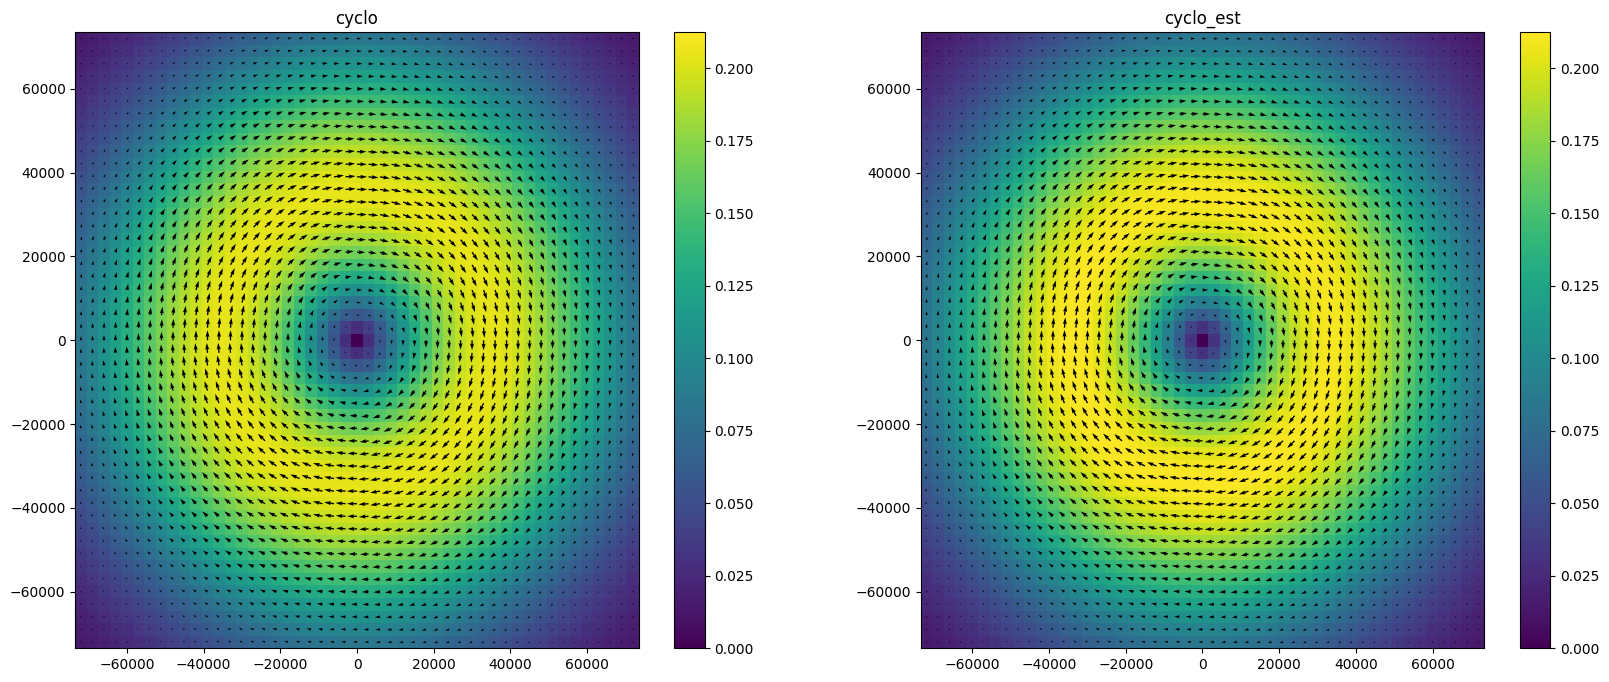

In [17]:
vmax = np.max([azim_cyclo, azim_cyclo_est])
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.set_title("cyclo")
im = ax1.pcolormesh(X, Y, azim_cyclo, shading="auto", vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax1)
ax1.quiver(X, Y, u_cyclo, v_cyclo, color='k')
ax2.set_title("cyclo_est")
im = ax2.pcolormesh(X, Y, azim_cyclo_est, shading="auto", vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax2)
ax2.quiver(X, Y, u_cyclo_est, v_cyclo_est, color='k')
plt.show()

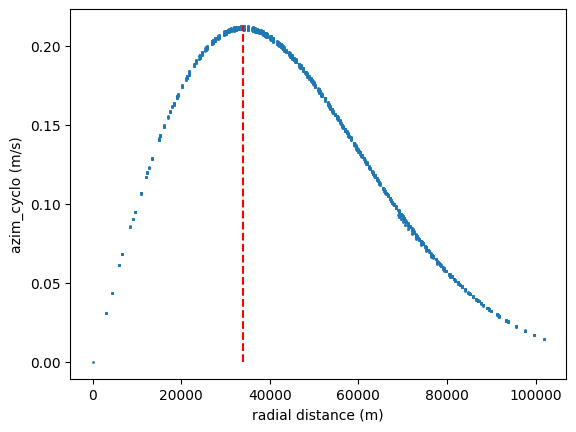

In [18]:
ax = plt.subplot()
ax.set_xlabel("radial distance (m)")
ax.set_ylabel("azim_cyclo (m/s)")
ax.scatter(R.flatten(), azim_cyclo_est.flatten(), s=1)
ax.vlines(R.flatten()[np.abs(azim_cyclo_est).flatten().argmax()], 
          ymin=azim_cyclo_est.min(), ymax=azim_cyclo_est.max(), colors="r", linestyles="dashed")
plt.show()

In [19]:
ge.compute_rmse(u_cyclo, u_cyclo_est), ge.compute_rmse(v_cyclo, v_cyclo_est)

(0.0033291178185321795, 0.0032672648957316405)

### Iterative estimation

$\mathbf{u}^{(n+1)} = \mathbf{u_g} + \frac{\mathbf{k}}{f} \times (\mathbf{u}^{(n)} \cdot \nabla \mathbf{u})^{(n)}$

#### Ioannou

Use of a convolution filter when computing the residuals.

In [20]:
u_cyclo_est, v_cyclo_est = cyclogeostrophy(u_geos, v_geos, dXY, dXY, dXY, dXY, coriolis_factor, coriolis_factor, method="ioannou")
azim_cyclo_est = ge.compute_azimuthal_magnitude(u_cyclo_est, v_cyclo_est)

  4%|▍         | 4/100 [00:00<00:00, 713.89it/s]


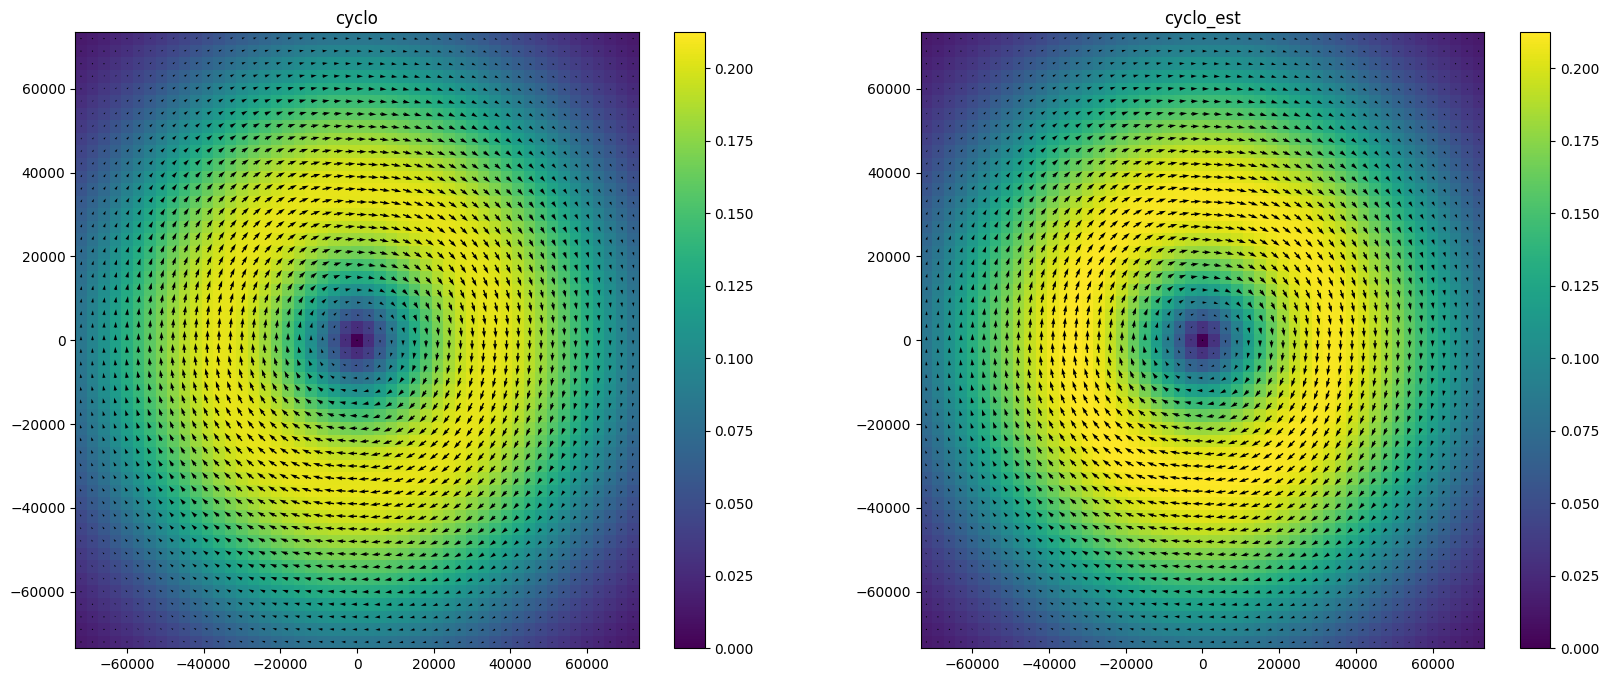

In [21]:
vmax = np.max([azim_cyclo, azim_cyclo_est])
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.set_title("cyclo")
im = ax1.pcolormesh(X, Y, azim_cyclo, shading="auto", vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax1)
ax1.quiver(X, Y, u_cyclo, v_cyclo, color='k')
ax2.set_title("cyclo_est")
im = ax2.pcolormesh(X, Y, azim_cyclo_est, shading="auto", vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax2)
ax2.quiver(X, Y, u_cyclo_est, v_cyclo_est, color='k')
plt.show()

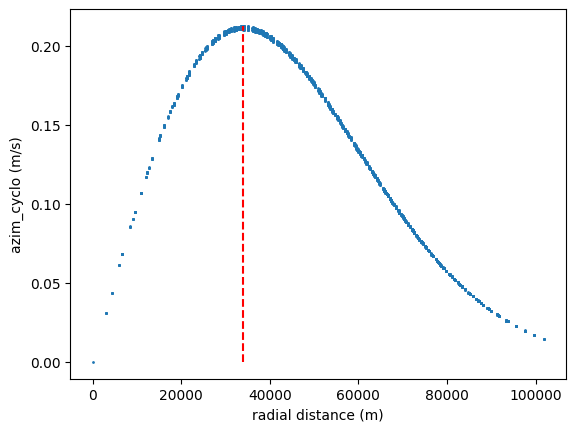

In [22]:
ax = plt.subplot()
ax.set_xlabel("radial distance (m)")
ax.set_ylabel("azim_cyclo (m/s)")
ax.scatter(R.flatten(), azim_cyclo_est.flatten(), s=1)
ax.vlines(R.flatten()[np.abs(azim_cyclo_est).flatten().argmax()], 
          ymin=azim_cyclo_est.min(), ymax=azim_cyclo_est.max(), colors="r", linestyles="dashed")
plt.show()

In [23]:
ge.compute_rmse(u_cyclo, u_cyclo_est), ge.compute_rmse(v_cyclo, v_cyclo_est)

(0.003233141199482752, 0.0032331411994827525)

#### Penven

No convolution filter, original approach.

In [24]:
u_cyclo_est, v_cyclo_est = cyclogeostrophy(u_geos, v_geos, dXY, dXY, dXY, dXY, coriolis_factor, coriolis_factor, method="penven")
azim_cyclo_est = ge.compute_azimuthal_magnitude(u_cyclo_est, v_cyclo_est)

  4%|▍         | 4/100 [00:00<00:00, 1861.45it/s]


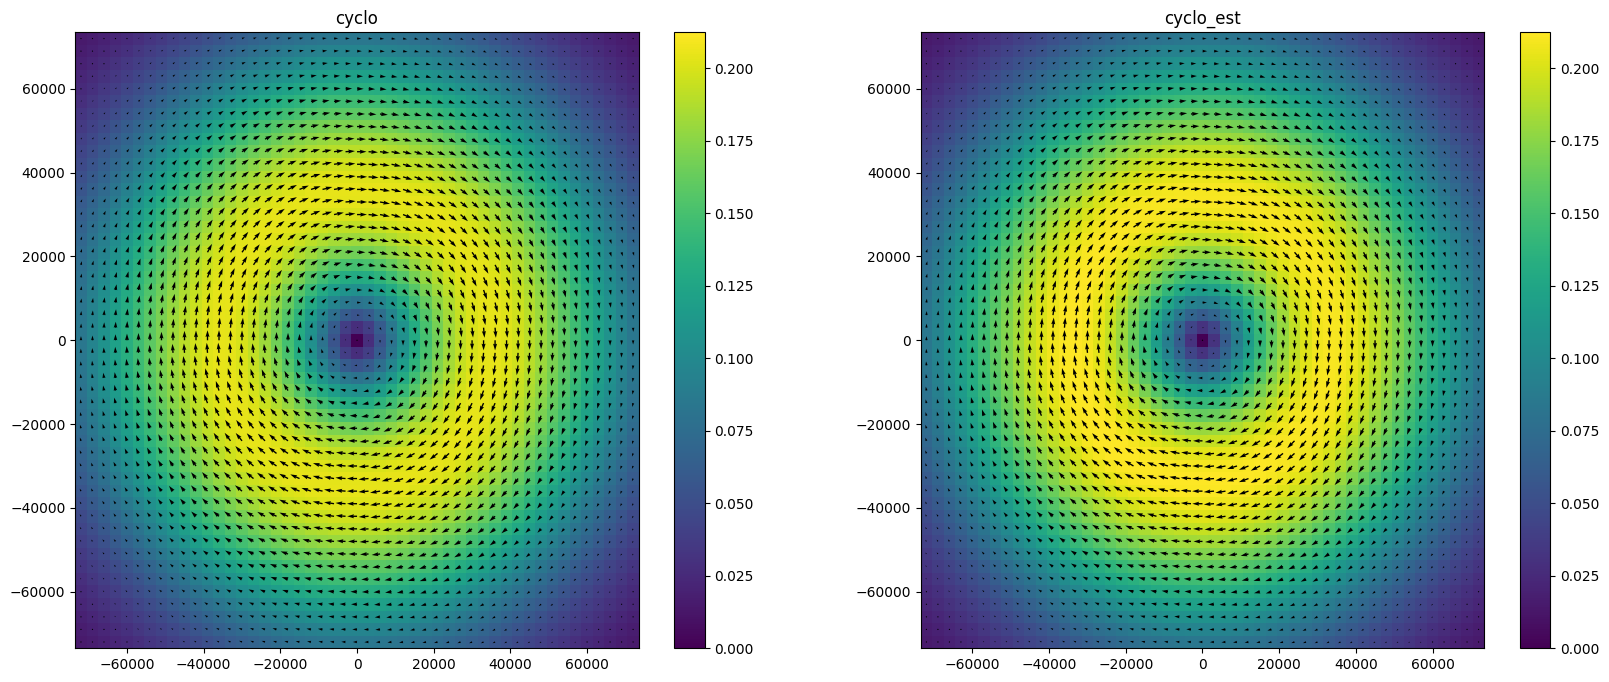

In [25]:
vmax = np.max([azim_cyclo, azim_cyclo_est])
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.set_title("cyclo")
im = ax1.pcolormesh(X, Y, azim_cyclo, shading="auto", vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax1)
ax1.quiver(X, Y, u_cyclo, v_cyclo, color='k')
ax2.set_title("cyclo_est")
im = ax2.pcolormesh(X, Y, azim_cyclo_est, shading="auto", vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax2)
ax2.quiver(X, Y, u_cyclo_est, v_cyclo_est, color='k')
plt.show()

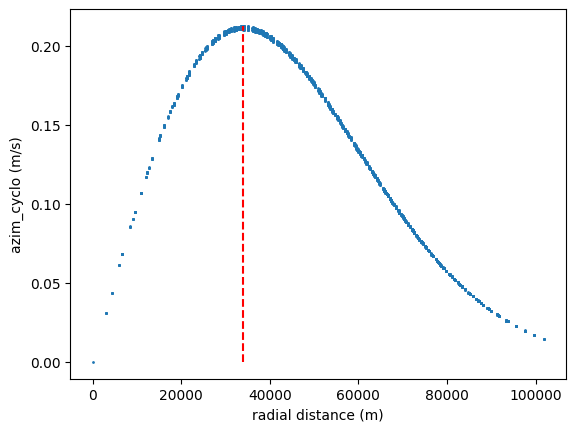

In [26]:
ax = plt.subplot()
ax.set_xlabel("radial distance (m)")
ax.set_ylabel("azim_cyclo (m/s)")
ax.scatter(R.flatten(), azim_cyclo_est.flatten(), s=1)
ax.vlines(R.flatten()[np.abs(azim_cyclo_est).flatten().argmax()], 
          ymin=azim_cyclo_est.min(), ymax=azim_cyclo_est.max(), colors="r", linestyles="dashed")
plt.show()

In [27]:
ge.compute_rmse(u_cyclo, u_cyclo_est), ge.compute_rmse(v_cyclo, v_cyclo_est)

(0.003233132676525826, 0.003233132676525826)